In [93]:
import numpy as np


# initial states, zero initial velocity
x0 = [-3, 0, 9, 0, 0, 0]
# coefficient of friction
mu = 0.15
# coefficient of restitution (v2 = CoR*v1)
CoR = 0.5
# air damping (f = -ad*v)
ad = 0.005
# parabola damping
pd = 0.01
# mass
m = 0.5
# gravity constant
g = 9.8
# time step
dt = 0.005
# state vector 
state = np.array(x0)
# damping?
enable_damping = True
# friction?
enable_friction = True

In [89]:
# step function of the free-fall phase
def step_free_fall(state, enable_damping=False):
    x, y, z, dx, dy, dz = state
    if not enable_damping:
        dstate = np.array([dx, dy, dz, 0, 0, -g])
    else:
        dstate = np.array([dx, dy, dz, -ad*dx/m, -ad*dy/m, -g-ad*dz/m])
    new_state = state + dstate * dt
    return new_state

# step function of the bouncing phase
def step_bounce(state):
    x, y, z, dx, dy, dz = state
    # at the momemnt of contact we assume no motion at all, just a bounce
    new_state = np.array([x, y, 0, dx, dy, -CoR*dz])
    return new_state

# step function of the parabola phase
def step_parabola(state, enable_friction=False, enable_damping=False):
    x, y, z, dx, dy, dz = state
    # two forces are in the play: gravity and the support force from the curvature
    # gravity force is easy -> [0, 0, -mg]
    # support force is normal to the curvature while providing the centripetal 
    # force so that the object moves along the curvature/parabola; therefore
    # it needs to be larger than the gravity's component along the curvature's
    # radius
    # assume the object can move past the parabola
    r = np.sqrt((4*x**2+1)**3)/2  # 1/(curvature of y=x^2): https://www.wolframalpha.com/input/?i=curvature+of+y%3Dx%5E2
    k = 2*x # slope for future convenience
    k_u = np.array([1, k])/np.sqrt(k**2+1) # unit vector along the slope
    k_n = np.array([-k_u[1], k_u[0]]) # normal vector along the slope
    v = np.array([dx, dz]) # velocity of the object in x-z plane
    netN = (np.dot(k_u, v)**2)/r # net normal acceleration along the radius of the curvature
    N = netN + g/np.sqrt(k**2+1) # total normal acceleration
    # the acceleration vectors are in the xz-plane
    Nvector = N*k_n
    total_acc_vector = Nvector + np.array([0, -g])
    acc_x = total_acc_vector[0]
    acc_z = total_acc_vector[1]
    if not enable_friction and not enable_damping:
        dstate = np.array([dx, dy, dz, acc_x, 0, acc_z])
    elif not enable_damping:
        # # determine if the object is moving forward or back
        # direction = 1 if dx > 0 else -1
        friction = -mu*N*k_u
        dstate = np.array([dx, dy, dz, acc_x + friction[0], 0, acc_z + friction[1]])
    else:
        # considering air damping AND the ramp damping
        # direction = 1 if dx > 0 else -1
        friction = -mu*N*k_u
        dstate = np.array([dx, dy, dz, acc_x + friction[0] - (ad+pd)*dx/m, -(ad+pd)*dy/m, acc_z + friction[1] - (ad+pd)*dz/m])

    new_state = state + dstate * dt
    # # regulate the position
    # new_state[2] = new_state[0]**2
    return new_state

In [90]:
def simulate(init_state, end_parabola_x, enable_friction=False, enable_damping=False, time_out=10):
    length = int(time_out//dt)
    state_log = np.zeros((length, 6))
    state = init_state
    count = 0
    while count < length:
        state_log[count, :] = state
        if state[0] <= end_parabola_x:
            state = step_parabola(state, enable_friction, enable_damping)
        elif state[2]<0:
            state = step_bounce(state)
        else:
            state = step_free_fall(state, enable_damping)
        count += 1
    return state_log

In [94]:
state_log = simulate(x0, 1, enable_friction, enable_damping)
print(len(state_log))

1999


In [5]:
!pip install JSAnimation

  Created wheel for JSAnimation: filename=JSAnimation-0.1-cp36-none-any.whl size=11426 sha256=b18f3a9e973394df60833fb35f20d3f37d3de50f30108a7b741c7b387e58bd2b
  Stored in directory: /root/.cache/pip/wheels/3c/c2/b2/b444dffc3eed9c78139288d301c4009a42c0dd061d3b62cead
Successfully built JSAnimation


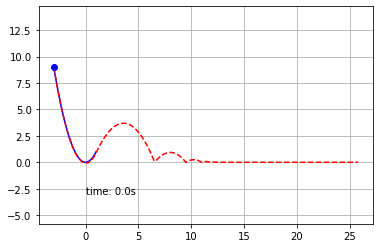

In [95]:
import matplotlib.pyplot as plt
from matplotlib import animation
from JSAnimation import IPython_display
from IPython.display import HTML

path = np.zeros((50, 2))
path[:,0] = np.linspace(-3,1)
for i in range(len(path)):
    path[i,1] = path[i,0]**2

fig, ax = plt.subplots()
plt.axis('equal')
sampling = int(10)

def animate(t):
    ax.clear()
    plt.grid()
    
    # Path
    plt.plot(path[:,0], path[:,1], 'b')
    # trajectory
    plt.plot(state_log[::sampling,0], state_log[::sampling,2], 'r--')
    
    # current position
    plt.plot(state_log[sampling*t,0], state_log[sampling*t,2], 'ko')
    plt.arrow(state_log[sampling*t,0], state_log[sampling*t,2], state_log[sampling*t,3], state_log[sampling*t,5])
    plt.text(0,-3,"time: {:.1f}s".format(t*dt*sampling))
    
    
time = int(len(state_log)/sampling)
anim = animation.FuncAnimation(fig, animate, frames=time, interval=dt*1000*sampling)

HTML(anim.to_jshtml())